In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from nn_interpretability.interpretation.backprop.vanilla_backprop import VanillaBackprop
from nn_interpretability.interpretation.backprop.guided_backprop import GuidedBackprop
from nn_interpretability.interpretation.backprop.integrated_grad import IntegratedGrad
from nn_interpretability.interpretation.backprop.smooth_grad import SmoothGrad
from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
model_name = 'model_cnn.pt'

train = False

In [3]:
mnist_data_loader = MnistDataLoader()

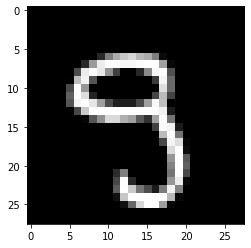

In [4]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

In [5]:
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, mnist_data_loader.trainloader)
    
    ModelRepository.save(model, model_name)

# I. Vanilla Backpropagation

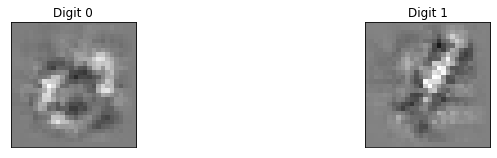

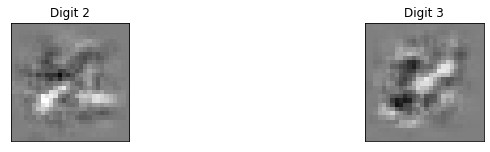

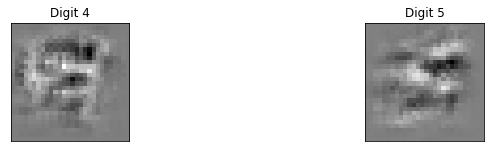

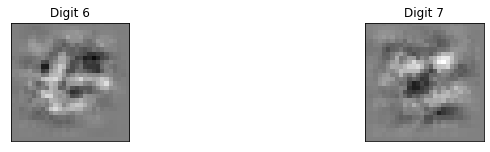

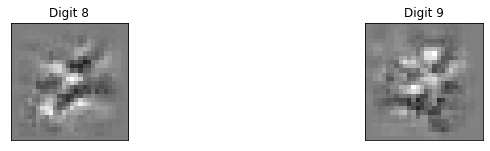

In [6]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    
    interpretor = VanillaBackprop(model, [], None)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)
    
    images.append(endpoint.detach().numpy().reshape(img_shape))
    
MnistVisualizer.display_images_for_each_class(images)

# II. Guided Backpropagation

## 1. Guided Backpropagation

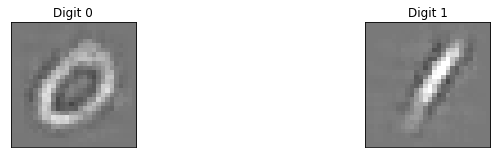

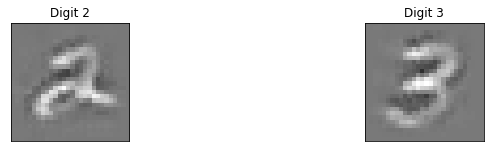

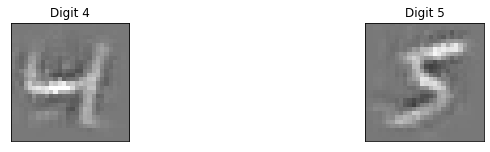

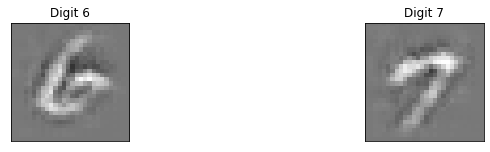

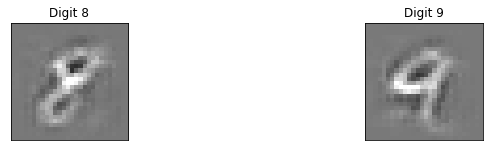

In [8]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    
    interpretor = GuidedBackprop(model, [], None)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)

    images.append(endpoint.detach().numpy().reshape(img_shape))

MnistVisualizer.display_images_for_each_class(images)

## 2. Guided Backpropagation + SmoothGrad

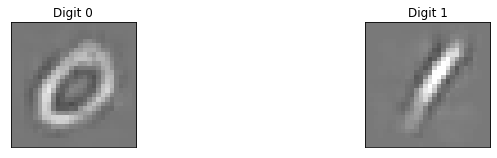

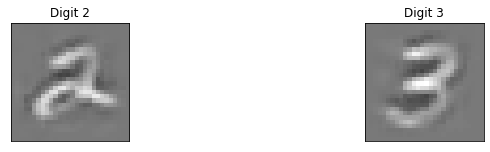

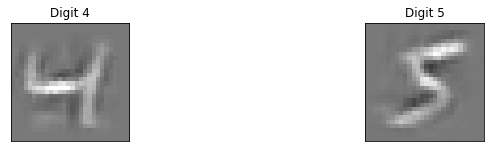

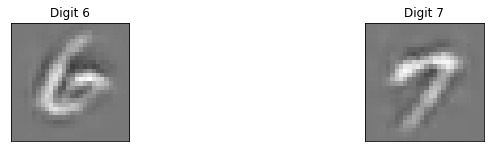

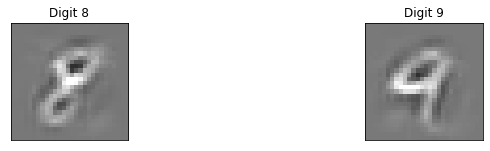

In [11]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    
    interpretor = GuidedBackprop(model, [], None, True, 0.8, 100)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)

    images.append(endpoint.detach().numpy().reshape(img_shape))

MnistVisualizer.display_images_for_each_class(images)

# III. Integrated Gradients

## 1. Integrated Gradients

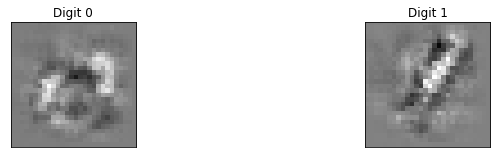

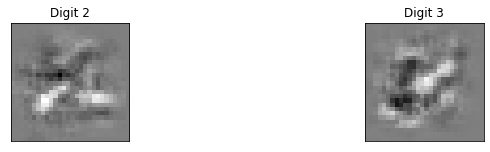

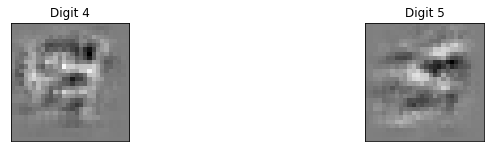

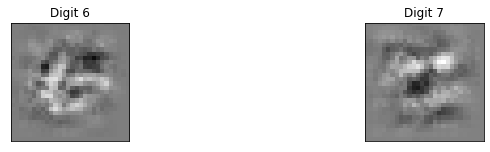

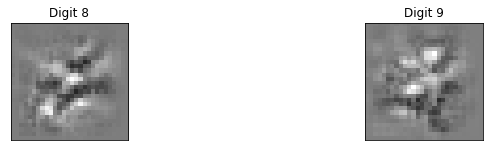

In [7]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    baseline = torch.zeros(img.size())

    interpretor = IntegratedGrad(model, [], None, baseline, 100)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)
    
    images.append(endpoint.detach().numpy().reshape(img_shape))

MnistVisualizer.display_images_for_each_class(images)

## 2. Integrated Gradients + SmoothGrad

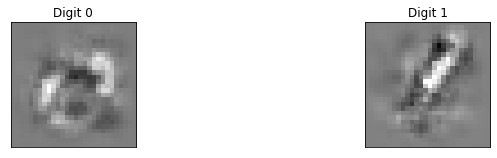

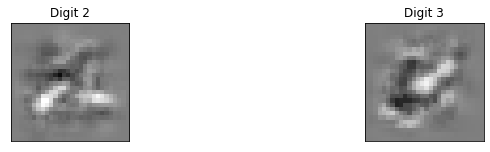

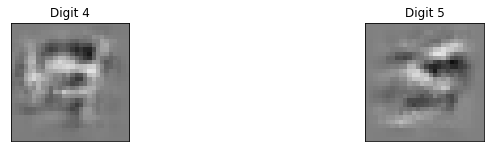

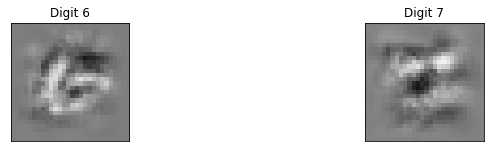

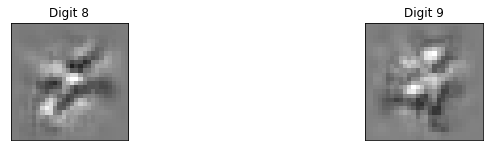

In [9]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    baseline = torch.zeros(img.size())

    interpretor = IntegratedGrad(model, [], None, baseline, 100, True, 0.5)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)

    images.append(endpoint.detach().numpy().reshape(img_shape))

MnistVisualizer.display_images_for_each_class(images)

# IV. SmoothGrad

## 1. Analyze gradient noise
This is an experiement form the paper "SmoothGrad: removing noise by adding noise" to analyze how human indistinguishable Gaussian noise can affect the gradient fluctuation.

Baseline image v.s. Perturbed image


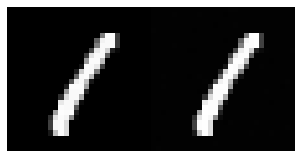

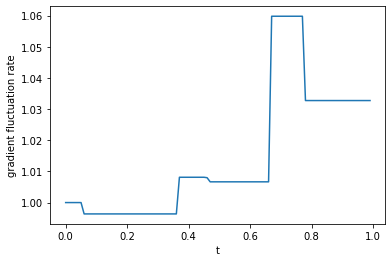

In [28]:
import matplotlib.pyplot as plt
img = mnist_data_loader.get_image_for_class(1).cpu()

noise = torch.zeros(img.size()).normal_(0.01, 0.001)
gradient_list = []
steps = 100

interpretor = VanillaBackprop(model, [], None)
reference = interpretor.interpret(img)
reference = torch.max(torch.abs(reference)).item()

for i in range(steps):
    img_noise = img + (i*noise / steps)
    saliency = interpretor.interpret(img_noise)
    max_gradient = torch.max(torch.abs(saliency)).item()/reference
    gradient_list.append(max_gradient)


print("Baseline image v.s. Perturbed image")
MnistVisualizer.cat_images([img, img_noise], 4, 4)
plt.plot([x/100 for x in range(steps)], gradient_list)
plt.xlabel('t')
plt.ylabel('gradient fluctuation rate')
plt.show()

## 2. SmoothGrad

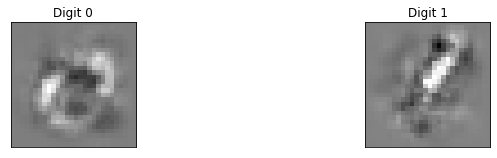

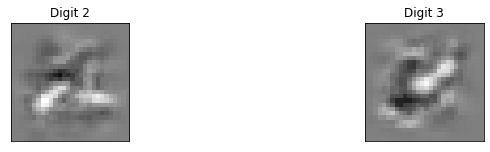

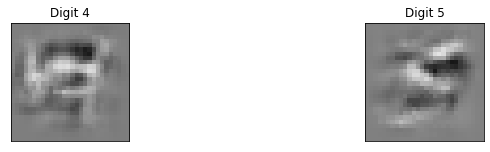

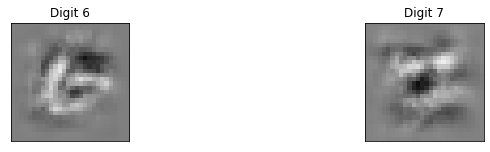

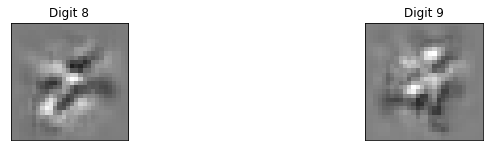

In [30]:
images = []
img_shape = (28, 28)

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i)
    
    interpretor = SmoothGrad(model, [], None, 0.8, 100)
    endpoint = interpretor.interpret(img)
    endpoint = MnistVisualizer.normalize(endpoint)

    images.append(endpoint.detach().numpy().reshape(img_shape))

MnistVisualizer.display_images_for_each_class(images)